# 🔬 Feature Selection with Binomial Deviance

To reduce dimensionality and retain informative biological signals, we select a subset of highly deviant genes using the `scry` R package. This method avoids the biases introduced by log-transformation and pseudo-counts.


In [1]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scanpy as sc

import rpy2.robjects as ro
import rpy2.rinterface_lib.callbacks as rcb
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

# 📥 Load normalized dataset
adata = sc.read("../../data/breast_cancer_normalized_all_layers.h5ad")

# 📦 R interface settings
rcb.logger.setLevel(logging.ERROR)
pandas2ri.activate()

# 👇 Required to use %%R magic
%load_ext rpy2.ipython


## 📊 Identify Highly Deviant Genes with `scry` in R


In [3]:
from scipy.sparse import issparse
import rpy2.robjects as ro

# Extract gene-by-cell matrix
raw_counts = adata.X.T  # transpose to match R format (genes x cells)

# Convert to dense if needed
if issparse(raw_counts):
    raw_counts = raw_counts.toarray()

# Send to R
ro.globalenv["raw_counts"] = raw_counts

ro.globalenv["gene_names"] = adata.var_names.to_list()
ro.globalenv["cell_names"] = adata.obs_names.to_list()


In [4]:
%%R
library(scry)
library(SingleCellExperiment)

# Create SingleCellExperiment
sce <- SingleCellExperiment(list(counts = raw_counts))

# Optional: assign row/colnames
rownames(sce) <- gene_names
colnames(sce) <- cell_names

# Run deviance feature selection
sce <- devianceFeatureSelection(sce)
binomial_deviance <- rowData(sce)$binomial_deviance


## 🧬 Select Top 4000 Highly Deviant Genes


In [5]:
import numpy as np

binomial_deviance = np.array(ro.r("binomial_deviance"))

# Select top 4000 genes
idx = binomial_deviance.argsort()[-4000:]
mask = np.zeros(adata.var_names.shape, dtype=bool)
mask[idx] = True

# Store in adata.var
adata.var["highly_deviant"] = mask
adata.var["binomial_deviance"] = binomial_deviance


## 🧪 Compare to Scanpy's Mean/Dispersion Metrics


In [7]:
sc.pp.highly_variable_genes(adata, layer="scran_normalization")


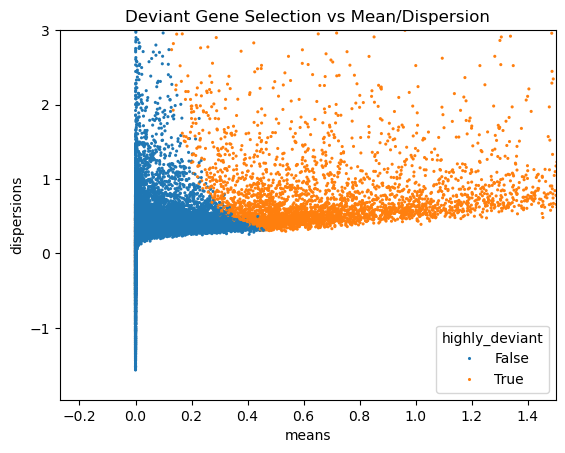

In [8]:
ax = sns.scatterplot(
    data=adata.var,
    x="means", y="dispersions",
    hue="highly_deviant", s=5, linewidth=0
)
ax.set_xlim(None, 1.5)
ax.set_ylim(None, 3)
plt.title("Deviant Gene Selection vs Mean/Dispersion")
plt.show()


## 💾 Save Feature-Selected Dataset


In [9]:
adata.write("../../data/breast_cancer_feature_selection.h5ad")
print("✅ Saved to 'breast_cancer_feature_selection.h5ad'")


✅ Saved to 'breast_cancer_feature_selection.h5ad'


### Feature Selection via Deviance
We applied binomial deviance-based feature selection using the `scry` R package. This method identifies genes that show significant variability across cells, avoiding the biases of pseudo-count log-transformation. The top 4000 most deviant genes were marked and used for downstream dimensionality reduction and clustering.
